### Reconstructing a brain phantom

The scanner organises the "coincidence" events in a format called a sinogram. This data is related to the true radiotracer distribution within the body through what is known as a Radon transform. To get the true radiotracer distribution (what we want), we have to reconstruct the image using these measured projections (the sinogram). This is what's known as an inverse problem.

In this notebook, we will focus on using the Radon transform to learn the concepts of forward and back projecting and how they link into reconstructing a 2D brain image


First lets import the libraries needed for the maths and plotting images and set up a few utility functions to help along the way

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize, radon, iradon
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm import trange

In [2]:
# Normalised Root Mean Square Error - Used to calculate the error between the true and reconstructed images

def normalised_root_mean_square_error(true, recon):
    return np.sqrt(np.mean((true - recon)**2)) / np.sqrt(np.mean(true**2))*100.0

### The phantom

We will be working with the following phantom:
<div>
<img src="brain.png" width="200"/>
</div>

This phantom is a 2D image, below is some code that will import the file and resize it to a 256x256 image.

In [3]:
detailed_brain_phantom = loadmat('brain_phantom.mat')
true_image = detailed_brain_phantom['aphantom']

nxd = 128
true_image = 0.01*resize(true_image, (nxd,nxd), anti_aliasing=False)

## The Radon Transform: Creating the sinogram

The Radon transform is a mathematical operation that takes a 2D image and maps it into a 2D space. This is done by projecting the image along a line at a certain angle. The result of this projection is a 1D signal that is stored in a sinogram. The sinogram is a 2D array where the x-axis represents the angle of projection and the y-axis represents the distance along the projection line.

For full coverage of the image, the projection has to be carried out at multiple angles, typically 180 degrees.

Complete the following code to create an array of angles between 0 and 180 degrees. `np.arange` takes in the start, stop and step size of the array.

In [4]:
angles = np.arange(0, 180, 1)

We can use the `radon` function from the `skimage.transform` module to create the sinogram. This function takes the image and the array of angles as input and returns the sinogram. Complete the following code the create the sinogram of the brain phantom.

The `circle` parameter should be set to `False` to avoid the image being cropped to a circle.

In [5]:
sinogram = radon(true_image, angles, circle=False)

Now we have forward projected the image to obtain our sinogram, let's see how the sinogram and the brain phantom looks.

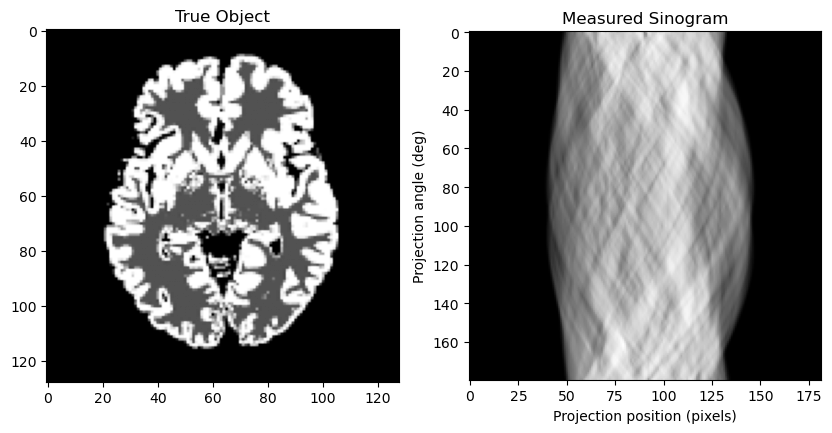

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# imshow is used to plot 2D images with the use of matplotlib. We will use the 'Greys_r' colour map to show greyscale images.
ax[0].imshow(true_image, cmap='Greys_r') 
ax[0].set_title('True Object') 

ax[1].imshow(sinogram.T, cmap='Greys_r') # Transpose to match the orientation of the phantom
ax[1].set_xlabel('Projection position (pixels)'); ax[1].set_ylabel('Projection angle (deg)')
ax[1].set_title('Measured Sinogram')

plt.show()

Similar to the `radon` function, which forward projects an image, the `iradon` function can be used to **_back_** project a sinogram to get a crude reconstruction. This function takes the sinogram and the array of angles as input and returns the reconstructed image. Complete the following code to reconstruct the image from the sinogram.

As before, the `circle` parameter should be set to `False` to avoid the image being cropped to a circle. Also, the `filter_name` parameter should be set to `None` to avoid applying a filter to the sinogram.

In [7]:
bp_image = iradon(sinogram, angles, filter_name=None, circle=False)

Complete the following code to plot the true image, and the backprojected image.

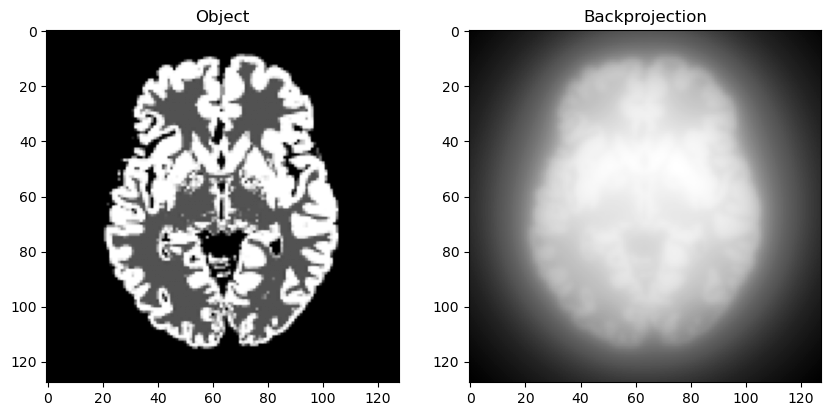

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(true_image, cmap='Greys_r') 
ax[0].set_title('Object') 

ax[1].imshow(bp_image, cmap='Greys_r') # Transpose to match the orientation of the phantom
ax[1].set_title('Backprojection')

plt.show()

## Iterative reconstruction: MLEM method

We can see that this image is very blurry and does not resemble the original image, this is because only using the back projection oversamples certain parts of the image. To improve the reconstruction, lets look at a method called Maximum Likelihood Expectation Maximisation (MLEM), an iterative method.

MLEM starts with a guess of what the image might look like. We can then simulate what data this guessed image would produce using the Radon transform. By comparing this simulated data to the actual data, we can improve our guess. This process is repeated many times to get a better image.

Therefore, we can think of the process as follows:
1. Start with an initial guess of the image (usually an image set to all ones)
2. Forward project the image to get an estimate sinogram
3. Divide the actual measured sinogram by the estimated sinogram, this is essentially a factor saying how far off the estimate is from the actual sinogram
4. Back project this factor to get a value to multiply the initial guess 
5. Multiply the initial guess by this correction factor and include additional correction term
6. Repeat 2-5 until the image converges to a satisfactory level

The following is the function that carries out an MLEM update (steps 2-5); it takes in the current image, and the measured sinogram. Complete this function. 

By having this function, we can now iterate over the image to get a better reconstruction. Also, as move on to the next tasks, we can make use of this function, so it's important to get it right the first time!

In [9]:
def MLEM_update(current_estimate, measured_sinogram):
    # An additional correction term needed for a correct reconstruction
    sensitivity_image = iradon(np.ones_like(measured_sinogram), angles, filter_name=None, circle=False)
    # Step 2: Forward project the estimate image
    sino_estimate = radon(current_estimate, angles, circle=False)
    # Step 3: Divide measured sinogram by the estimate sinogram (add a small number in denominator to avoid division by zero)
    measured_vs_estimate_ratio = measured_sinogram / (sino_estimate + 1e-15)
    # Step 4: Backproject the ratio
    bp_ratio = iradon(measured_vs_estimate_ratio, angles, filter_name=None, circle=False)
    # Step 5: Multiply the estimate by the backprojected ratio and divide by sensitivty image for correct reconstruction
    current_estimate = bp_ratio * current_estimate / (sensitivity_image + 1e-15)

    return current_estimate

Now, lets include a for loop that will iterate over the MLEM update over a certain number of iterations. We can set the number of iterations using `n_iter`. 

After each update, we also calculate the normalised root mean square error (NRMSE) between the true image and the current image. This is a measure of how close the current image is to the true image. We can plot this later to see how the image converges (or not!).

In [10]:
# Step 1: Create a blank image filled with ones as our first estimate
mlem_recon_image = np.ones_like(true_image)

# Set the number of iterations for the iterative reconstruction and create an empty list to store the NRMSE values
n_iter = 40
NRMSE_list = []

# Create a progress bar for the iterations
iteration_progress_bar = trange(n_iter, desc='MLEM Iterations', leave=True)

# Set up the loop for iterative reconstruction
for i in iteration_progress_bar:
    mlem_recon_image = MLEM_update(current_estimate=mlem_recon_image, measured_sinogram=sinogram)

    # Extra: Calculate the NRMSE and append to the list
    NRMSE_list.append(normalised_root_mean_square_error(true_image, mlem_recon_image))
    iteration_progress_bar.set_postfix_str(f'NRMSE: {NRMSE_list[-1]:.2f} %')
    

MLEM Iterations: 100%|██████████| 40/40 [00:03<00:00, 13.32it/s, NRMSE: 24.44 %]


Complete the following code to plot the true image and the MLEM reconstructed image. Also plot the error between the true brain phantom and the reconstruction (use `NRMSE_list`); complete `ax[2].plot("")` for this.

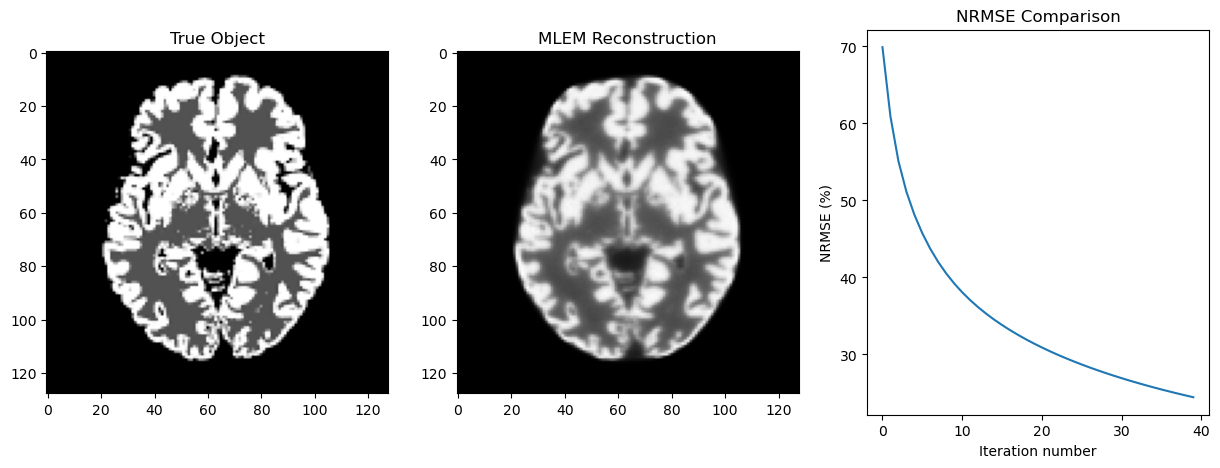

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(true_image, cmap='Greys_r') 
ax[0].set_title('True Object') 

ax[1].imshow(mlem_recon_image, cmap='Greys_r')
ax[1].set_title('MLEM Reconstruction')

ax[2].plot(NRMSE_list)
ax[2].set_xlabel('Iteration number'); ax[2].set_ylabel('NRMSE (%)')
ax[2].set_title('NRMSE Comparison')

plt.show()

We should be able to see an image somewhat resembling the true brain phantom, experiment with the number of iterations to see how the reconstruction changes. Does it get better?

### Noisy data

In reality, the data collected by the scanner is noisy. With noisy data, MLEM reconstruction can struggle. However, there are some ways in reducing the effect of noise in the reconstruction. One method is to use regularisation within the reconstruction.

First, lets create some noisy data by introducing Poisson noise (a particular type of noise that is common in PET imaging). This is done in the following code block.

In [17]:
noisy_sinogram = np.random.poisson(sinogram)

Lets compare the noisy sinogram to the true measured sinogram; using the plotting code from earlier, plot the noisy sinogram and the true sinogram.

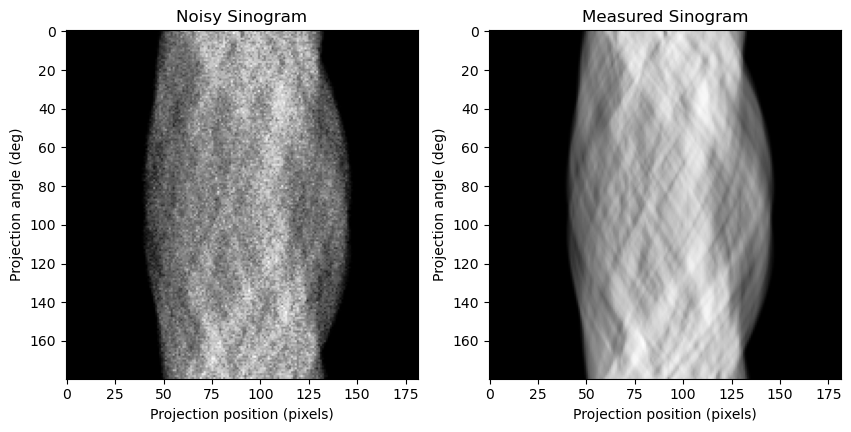

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(noisy_sinogram.T, cmap='Greys_r') 
ax[0].set_xlabel('Projection position (pixels)'); ax[0].set_ylabel('Projection angle (deg)')
ax[0].set_title('Noisy Sinogram') 

ax[1].imshow(sinogram.T, cmap='Greys_r') # Transpose to match the orientation of the phantom
ax[1].set_xlabel('Projection position (pixels)'); ax[1].set_ylabel('Projection angle (deg)')
ax[1].set_title('Measured Sinogram')

plt.show()

Next, using the MLEM implementation for the noise free data as a starting block, reconstruct the noisy data.

In [19]:
# Step 1: Create a blank image filled with ones as our first estimate and an additional correction term needed for a correct reconstruction
noisy_mlem_recon_image = np.ones_like(true_image)

# Set the number of iterations for the iterative reconstruction and create an empty list to store the NRMSE values
n_iter = 40
Noisy_NRMSE_list = []

# Create a progress bar for the iterations
noisy_iteration_progress_bar = trange(n_iter, desc='Noisy MLEM Iterations', leave=True)

# Set up the loop for iterative reconstruction
for i in noisy_iteration_progress_bar:
    # Step 2-5: Call MLEM_update to get the next update. Make sure to use the noisy sinogram this time!
    noisy_mlem_recon_image = MLEM_update(noisy_mlem_recon_image, noisy_sinogram)

    # Extra: Calculate the NRMSE and append to the list
    Noisy_NRMSE_list.append(normalised_root_mean_square_error(true_image, noisy_mlem_recon_image))
    noisy_iteration_progress_bar.set_postfix_str(f'NRMSE: {Noisy_NRMSE_list[-1]:.2f} %')

Noisy MLEM Iterations: 100%|██████████| 40/40 [00:03<00:00, 13.06it/s, NRMSE: 32.88 %]


Plot the reconstructions and the true image here. Also, as before, plot the NRMSE against iterations plot for the noisy data and the noise free data (in one plot). 

You can add additional lines to the plot by calling `ax[2].plot()` multiple times.

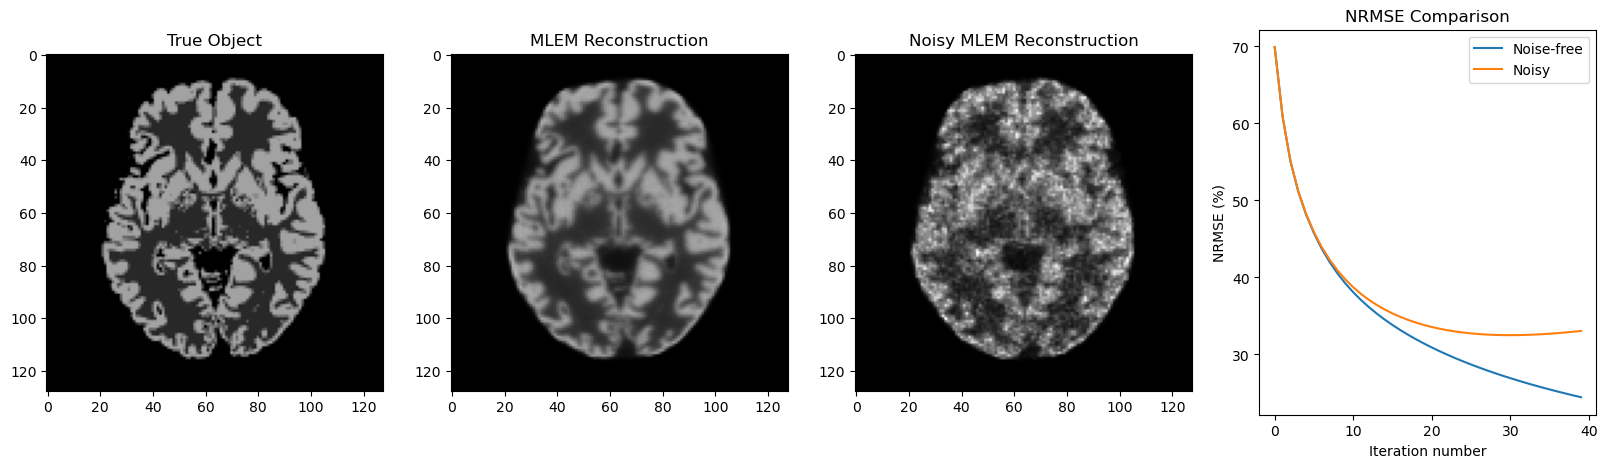

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(true_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')                # vmax is used to keep the same scale for all images, make sure to add this to the other plots
ax[0].set_title('True Object') 

ax[1].imshow(mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[1].set_title('MLEM Reconstruction')

ax[2].imshow(noisy_mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[2].set_title('Noisy MLEM Reconstruction')

ax[3].plot(NRMSE_list, label='Noise-free')
ax[3].plot(Noisy_NRMSE_list, label='Noisy')
ax[3].set_xlabel('Iteration number'); ax[3].set_ylabel('NRMSE (%)')
ax[3].legend()
ax[3].set_title('NRMSE Comparison')

plt.show()

As we can see from the noisy data reconstruction, the MLEM method struggles when significant noisy data is present in the data. Looking at the NRMSE plot, we should be able to see that the noisy data reconstruction diverges from the noise-free data reconstruction. This is where the MLEM method is trying to fit to the noise in the data rather than the actual data (or signal).

Regularisation of the MLEM reconstruction is one way to reduce the effects of noise. Here we will have a brief look at using a method, which instead of overfitting to noise, fits to a smoothed version of the data. 

The details of this method is quite complicated, but we can change a few parameters to see how the reconstruction difers to that of standard reconstruction of noisy data.

The following functions are part of the regularisation step. Don't worry too much about the detail here, but make sure to run the code block.

In [13]:
def compute_xreg(image_array, w):
    image = image_array.copy()
    padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    for x in range(1, image.shape[0] + 1):
        for y in range(1, image.shape[1] + 1):
            neighborhood = padded_image[x-1:x+2, y-1:y+2]
            image[x-1, y-1] += np.sum(w/2 * (padded_image[x, y] + neighborhood))

    return image

def compute_MAPEM_update(xEM, xreg, beta):
    return 2*xEM/(np.sqrt((1 - beta*xreg)**2 + 4*beta*xEM) + (1 - beta*xreg) + 1e-15)

As before, we start off with obtaining an MLEM update for the noisy data, but this time we will include the regularisation step. 

In [22]:
regularised_mlem_recon_image = np.ones_like(true_image)

# Regularisation parameters: w is constant, but feel free to change beta to see the effect on the reconstruction
w = np.array([[0., 1., 0.], [1., 0., 1.], [0., 1., 0.]])
w /= np.sum(w)
beta = .05       # Regularisation parameter: change as well as the number of iterations to see how the reconstruction changes

# Set the number of iterations for the iterative reconstruction and create an empty list to store the NRMSE values
n_iter = 40
Regularised_NRMSE_list = []

# Create a progress bar for the iterations
regularised_iteration_progress_bar = trange(n_iter, desc='Regularised MLEM Iterations', leave=True)

# Set up the loop for iterative reconstruction
for i in regularised_iteration_progress_bar:
    # Step 2-5: Call MLEM_update to get the next update. Make sure to use the noisy sinogram again!
    regularised_mlem_recon_image = MLEM_update(regularised_mlem_recon_image, noisy_sinogram)

    # Regularisation steps
    xreg = compute_xreg(regularised_mlem_recon_image, w)
    regularised_mlem_recon_image = compute_MAPEM_update(regularised_mlem_recon_image, xreg, beta)

    # Extra: Calculate the NRMSE and append to the list
    Regularised_NRMSE_list.append(normalised_root_mean_square_error(true_image, regularised_mlem_recon_image))
    regularised_iteration_progress_bar.set_postfix_str(f'NRMSE: {Regularised_NRMSE_list[-1]:.2f} %')

Regularised MLEM Iterations: 100%|██████████| 40/40 [00:05<00:00,  6.92it/s, NRMSE: 48.07 %]


Plot the true image, the noisy reconstruction, the noisy reconstruction with regularisation and the NRMSE plots for noise-free, noisy, and noisy with regularisation reconstructions

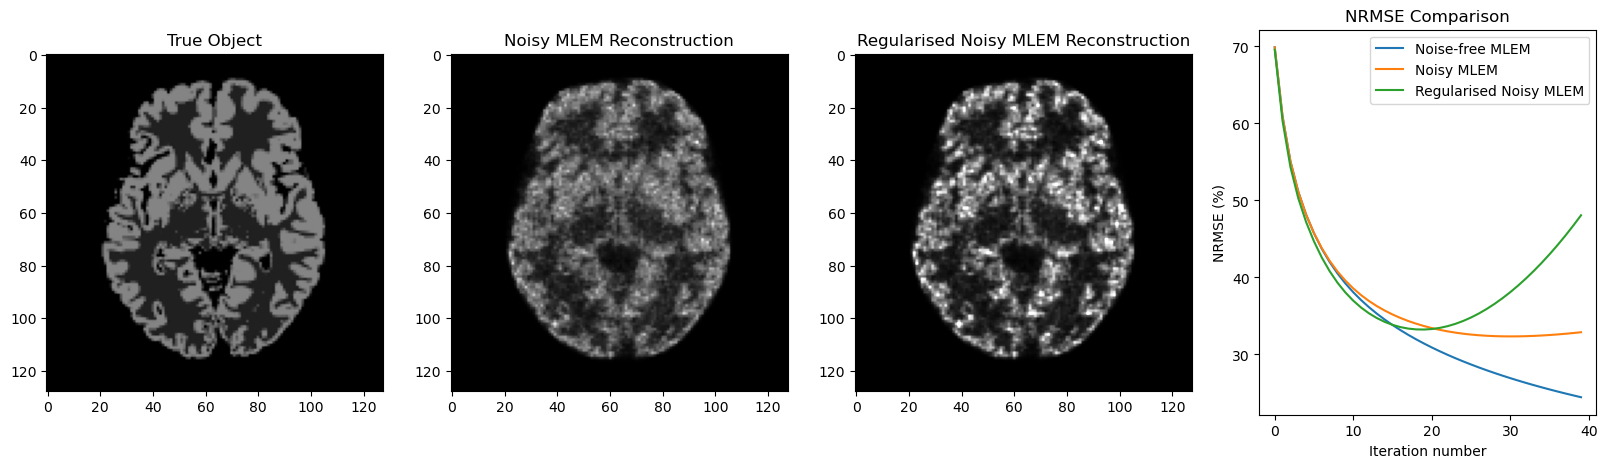

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(true_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r') 
ax[0].set_title('True Object') 

ax[1].imshow(noisy_mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[1].set_title('Noisy MLEM Reconstruction')

ax[2].imshow(regularised_mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[2].set_title('Regularised Noisy MLEM Reconstruction')

ax[3].plot(NRMSE_list, label='Noise-free MLEM')
ax[3].plot(Noisy_NRMSE_list, label='Noisy MLEM')
ax[3].plot(Regularised_NRMSE_list, label='Regularised Noisy MLEM')
ax[3].set_xlabel('Iteration number'); ax[3].set_ylabel('NRMSE (%)')
ax[3].legend()
ax[3].set_title('NRMSE Comparison')

plt.show()

Feel free to change around the values of `beta` and `n_iter` to see how the reconstruction changes. At the optimum values, you should be able to see a reconstruction that is less noisy than the noisy MLEM reconstruction; you should be able to see the features of the brain more clearly.

Lastly, we can apply post-smoothing to smooth out the image further to reduce the effects of noise. For this, we apply a simple Gaussian filter, where we specify the `sigma` value. This can provide an image that is more useful for a clinician, and is often used in practice too! Complete the following code to find the smooth versions of the noisy and regularised noisy reconstructions.

In [18]:
# Create a 2D Gaussian kernel to filter the image further 
def filter_image_with_gaussian(image, filt_sigma):
    filtered_image = gaussian_filter(image, filt_sigma)
    return filtered_image

sigma = 0.5

# Example usage:
smoothed_regularised_noisy_recon = gaussian_filter(regularised_mlem_recon_image, filt_sigma=sigma)
smoothed_noisy_recon = gaussian_filter(noisy_mlem_recon_image, filt_sigma=sigma)

Finally, plot the regularised noisy reconstruction as well as the smoothed version to see how they compare. Feel free to smooth the noisy reconstruction to see how that changes too. Change around `sigma` to see how this affects the reconstruction.

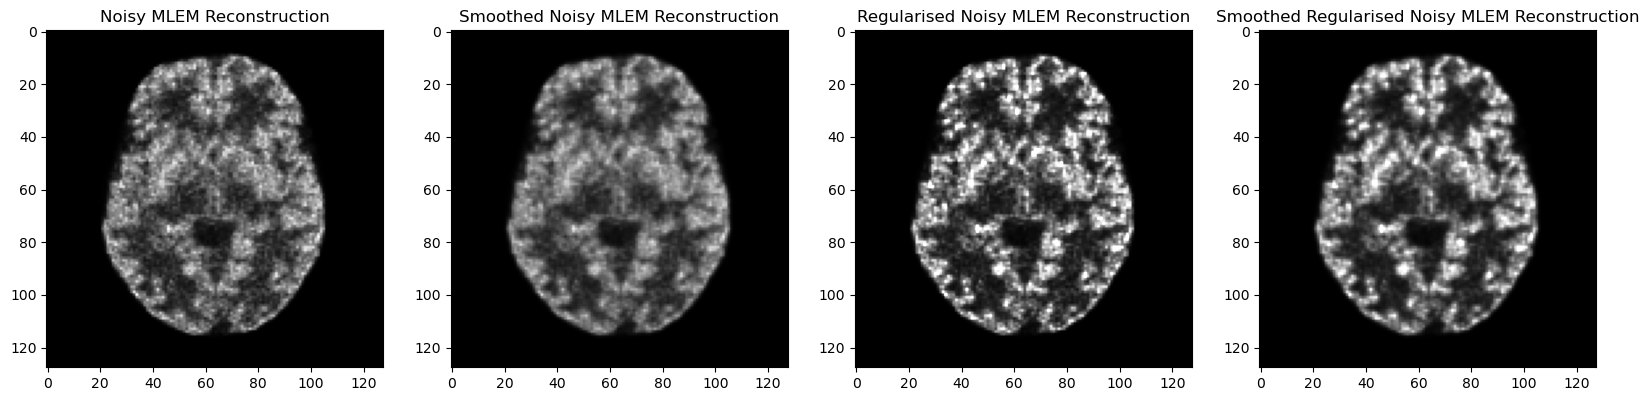

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(noisy_mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[0].set_title('Noisy MLEM Reconstruction')

ax[1].imshow(smoothed_noisy_recon, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[1].set_title('Smoothed Noisy MLEM Reconstruction')

ax[2].imshow(regularised_mlem_recon_image, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[2].set_title('Regularised Noisy MLEM Reconstruction')

ax[3].imshow(smoothed_regularised_noisy_recon, vmax=noisy_mlem_recon_image.max(), cmap='Greys_r')
ax[3].set_title('Smoothed Regularised Noisy MLEM Reconstruction')

plt.show()